In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
#%qtconsole

# 10 Approximate Bayesian Computation

## 10.1 The Variability Hypothesis

I have a soft spot for crank science. Recently I visited Norumbega
Tower, which is an enduring monument to the crackpot theories of Eben
Norton Horsford, inventor of double-acting baking powder and fake
history. But that’s not what this chapter is about.

This chapter is about the Variability Hypothesis, which

> “originated in the early nineteenth century with Johann Meckel, who
> argued that males have a greater range of ability than females,
> especially in intelligence. In other words, he believed that most
> geniuses and most mentally retarded people are men. Because he
> considered males to be the ’superior animal,’ Meckel concluded that
> females’ lack of variation was a sign of inferiority.”
>
> From <http://en.wikipedia.org/wiki/Variability_hypothesis>.

I particularly like that last part, because I suspect that if it turns
out that women are actually more variable, Meckel would take that as a
sign of inferiority, too. Anyway, you will not be surprised to hear that
the evidence for the Variability Hypothesis is weak.

Nevertheless, it came up in my class recently when we looked at data
from the CDC’s Behavioral Risk Factor Surveillance System (BRFSS),
specifically the self-reported heights of adult American men and women.
The dataset includes responses from 154407 men and 254722 women. Let's 
read in the data first (for the sake of simplicity the data was extracted and 
saved as a csv file).

In [2]:
df=pd.read_csv(r"../data/BRFSS.csv",sep=',',index_col=0)
M={'heights_all':df.M.dropna().values}
F={'heights_all':df.F.dropna().values}

Here’s what we found:

-   The average height for men is 178 cm; the average height for women
    is 163 cm. So men are taller, on average. No surprise there.

-   For men the standard deviation is 7.7 cm; for women it is 7.3 cm. So
    in absolute terms, men’s heights are more variable.

-   But to compare variability between groups, it is more meaningful to
    use the coefficient of variation (CV), which is the standard
    deviation divided by the mean. It is a dimensionless measure of
    variability relative to scale. For men CV is 0.0433; for women it is
    0.0444.

In [3]:
def cv(x): return x.std(ddof=1)/x.mean()
df.agg(('mean','std', cv, 'count'))

,M,F
mean,178.066221,163.223475
std,7.723563,7.269156
cv,0.043375,0.044535
count,154407.000000,254722.000000


That’s very close, so we could conclude that this dataset provides weak
evidence against the Variability Hypothesis. But we can use Bayesian
methods to make that conclusion more precise. And answering this
question gives me a chance to demonstrate some techniques for working
with large datasets.

I will proceed in a few steps:

1.  We’ll start with the simplest implementation, but it only works for
    datasets smaller than 1000 values.

2.  By computing probabilities under a log transform, we can scale up to
    the full size of the dataset, but the computation gets slow.

3.  Finally, we speed things up substantially with Approximate Bayesian
    Computation, also known as ABC.

## 10.2 Mean and standard deviation

In Chapter 9 we estimated two parameters simultaneously using
a joint distribution. In this chapter we use the same method to estimate
the parameters of a Gaussian distribution: the mean, `mu`,
and the standard deviation, `sigma`.

To do so, appropriate ranges for `mus` and `sigmas` have to be chosen. 
If the range is too small, we omit some possibilities with non-negligible 
probability and get the wrong answer. If the range is too big, we get the 
right answer, but waste computational power.

So this is an opportunity to use classical estimation to make Bayesian
techniques more efficient. Specifically, we can use classical estimators
to find a likely location for `mu` and `sigma`, and use the standard errors 
of those estimates to choose a likely spread.

If the true parameters of the distribution are $\mu$ and $\sigma$, and
we take a sample of $n$ values, an estimator of $\mu$ is the sample
mean, `mean`.

And an estimator of $\sigma$ is the sample standard variance,
`std`.

The standard error of the estimated $\mu$ is $s / \sqrt{n}$ and the
standard error of the estimated $\sigma$ is $s / \sqrt{2 (n-1)}$.

Finally, the range for $\mu$ is:
$$[\mu - SE_{\mu} \cdot n_{SE}; \mu + SE_{\mu} \cdot n_{SE}]$$
and for $\sigma$ is:
$$[\sigma - SE_{\sigma} \cdot n_{SE}; \sigma + SE_{\sigma} \cdot n_{SE}]$$

Here’s the code to compute all that:

In [94]:
def get_intervals(heights,n_se=4,n_vals_interval=31,n_vals_sample=100):
    
    mu = heights.mean()
    sigma = heights.std(ddof=1)
    count = heights.size

    se_mu = sigma / np.sqrt(count)
    se_sigma = sigma / np.sqrt(2*(count-1))

    mus= np.linspace( mu-n_se*se_mu, mu+n_se*se_mu, n_vals_interval )
    sigmas= np.linspace(sigma-n_se*se_sigma, sigma+n_se*se_sigma, n_vals_interval)
    
    return mus, sigmas 

#take first 100 datapoints for the analysis
M['heights_100']=M['heights_all'][0:1000]
F['heights_100']=F['heights_all'][0:1000]

M['mus'] , M['sigmas'] = get_intervals(M['heights_100'])
F['mus'] , F['sigmas'] = get_intervals(F['heights_100'])

`mus` is a sequence of possible values for `mu`;
`sigmas` is a sequence of values for `sigma`. The
prior distribution is uniform over all `mu, sigma` pairs.
`np.linspace` makes an array of 100 equally spaced elements between the 
left and rigth interval borders, including both.

The prior distribution is uniform over all mu, sigma pairs.

In [95]:
_mmsz=M['mus'].size
_mssz=M['sigmas'].size

prior = np.full((_mmsz, _mssz), fill_value=1/(_mmsz*_mssz), dtype = float)

The likelihood function is easy. Given hypothetical values of
`mus` and `sigmas`, we compute the likelihood of a
particular value, `x`. We do this using `scipy.stats.norm.pdf`
method. For example like this:

In [96]:
x=150
stats.norm.pdf(M['mus'][0],M['sigmas'][0],x)

0.0013851872516556943

If you have studied statistics from a mathematical perspective, you know
that when you evaluate a PDF, you get a probability density. In order to
get a probability, you have to integrate probability densities over some
range.

But for our purposes, we don’t need a probability; we just need
something proportional to the probability we want. A probability density
does that job nicely.



## 10.3 Update

Finally here’s the code to perform update for male and female data:

In [97]:
def update_i(mus,sigmas,heights):
    _runningprod = prior.copy()
    mg_mus, mg_sigmas = np.meshgrid(mus, sigmas, indexing='ij')
    mg_likelihood = stats.norm(mg_mus,mg_sigmas)
    for h in heights:
        _product = _runningprod * mg_likelihood.pdf(h)
        posterior = _product / _product.sum()
        _runningprod = posterior
    return posterior

def update_v(mus,sigmas,heights):
    mg_mus, mg_sigmas, mg_heights = np.meshgrid(mus, sigmas, heights, indexing='ij')
    mg_likelihood = stats.norm.pdf(x=mg_heights, loc=mg_mus,scale=mg_sigmas)
    posterior = prior * mg_likelihood.prod(axis=2)
    posterior /= posterior.sum()
    return posterior

M['posterior_100'] = update_v(M['mus'],M['sigmas'],M['heights_100'])
F['posterior_100'] = update_v(F['mus'],F['sigmas'],F['heights_100'])

/home/shk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


This process might seem bogus, because we use the data to choose the
range of the prior distribution, and then use the data again to do the
update. In general, using the same data twice is, in fact, bogus.

But in this case it is ok. Really. We use the data to choose the range
for the prior, but only to avoid computing a lot of probabilities that
would have been very small anyway. With `n_se=4`, the range is
big enough to cover all values with non-negligible likelihood. After
that, making it bigger has no effect on the results.

In effect, the prior is uniform over all values of `mu` and
`sigma`, but for computational efficiency we ignore all the
values that don’t matter.

## 10.4 The posterior distribution of CV

Once we have the posterior joint distribution of `mu` and
`sigma`, we can compute the distribution of CV for men and
women, and then the probability that one exceeds the other.

To compute the distribution of CV, we enumerate pairs of `mu`
and `sigma`, compute all possible CVs, sum the probabilities
for the same CV values and normalize. Below is function that 
does it:

In [90]:
def get_pmf_cv(mus,sigmas,posterior):
    mg_mus, mg_sigmas = np.meshgrid(mus, sigmas, indexing = 'ij')
    
    cv = (mg_sigmas / mg_mus).flatten()
    idx_sort = cv.argsort()
    cv = cv[idx_sort]
    
    pmf_cv = (posterior.flatten())[idx_sort]

    pmf_cv_unique_xk, cv_unique_idx = np.unique(cv,return_index=True) 
    pmf_cv_unique_pk = np.array(list(map( lambda x: x.sum(), np.split(pmf_cv_unique_xk,cv_unique_idx[1:]) ) ) )
    pmf_cv_unique_pk = pmf_cv_unique_pk / pmf_cv_unique_pk.sum()
    return pmf_cv_unique_xk, pmf_cv_unique_pk

Then we use function `get_prob_greater`, which computes the 
probability that one PMF is greater than another, to get the 
probability that men are more variable.

In [91]:
def get_prob_greater(G_pmf_xk,G_pmf_pk,S_pmf_xk,S_pmf_pk):
    mg_G_pmf_xk, mg_S_pmf_xk = np.meshgrid(G_pmf_xk,S_pmf_xk,indexing = 'ij')
    idx=mg_G_pmf_xk>mg_S_pmf_xk
    
    mg_G_pmf_pk, mg_G_pmf_pk = np.meshgrid(G_pmf_pk,S_pmf_pk,indexing = 'ij')    
    pg = (M_mg_pmf_pk[idx] * F_mg_pmf_pk[idx]).sum()
    return pg

Here is the code to run both functions:

In [92]:
M['pmf_cv_xk'], M['pmf_cv_pk'] = get_pmf_cv(M['mus'],M['sigmas'],M['posterior_100'])
F['pmf_cv_xk'], F['pmf_cv_pk'] = get_pmf_cv(F['mus'],F['sigmas'],F['posterior_100'])
pg = get_prob_greater(M['pmf_cv_xk'], M['pmf_cv_pk'],F['pmf_cv_xk'], F['pmf_cv_pk'])
print(f'probability of males being more variable than females is {pg:0.2f}')

probability of males being more variable than females is 0.51


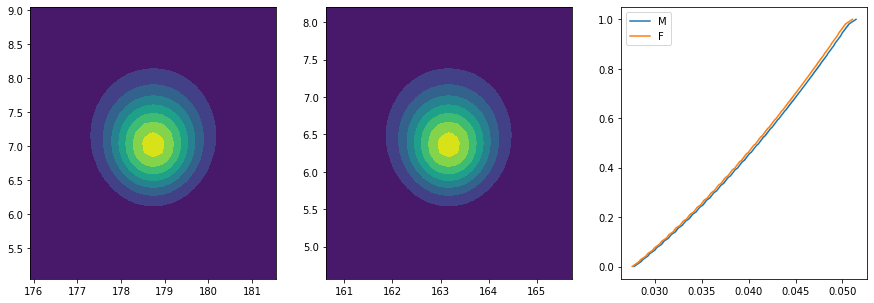

In [93]:
#Figure not in the original; Similar to Figures 10.1 10.2 10.3
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].contourf(M['mus'],M['sigmas'],M['posterior_100'].T)
axs[1].contourf(F['mus'],F['sigmas'],F['posterior_100'].T)
axs[2].plot(M['pmf_cv_xk'],M['pmf_cv_pk'].cumsum(),label='M')
axs[2].plot(F['pmf_cv_xk'],F['pmf_cv_pk'].cumsum(),label='F')
axs[2].legend()

The analysis itself is simple, but there are two more issues we have to
deal with:

1.  As the size of the dataset increases, we run into a series of
    computational problems due to the limitations of floating-point
    arithmetic.

2.  The dataset contains a number of extreme values that are almost
    certainly errors. We will need to make the estimation process robust
    in the presence of these outliers.

The following sections explain these problems and their solutions.

## 10.5 Underflow

If we select the first 100 values from the BRFSS dataset and run the
analysis I just described, it runs without errors and we get posterior
distributions that look reasonable.

If we select the first 1000 values and run the program again using, 
the vectorizd update function `update_v`we get an
error in `update_v`:

    RuntimeWarning: invalid value encountered in true_divide.

The problem is that we are using probability densities to compute
likelihoods, and densities from continuous distributions tend to be
small. And if you take 1000 small values and multiply them together, the
result is very small. In this case it is so small it can’t be
represented by a floating-point number, so it gets rounded down to zero,
which is called **underflow**. And if all probabilities in
the distribution are 0, it’s not a distribution any more.

A possible solution is to renormalize the PMF after each update, or
after each batch of 100. I defined a function `update_i` that does 
normalization after each update. Leveraging the speed of `numpy`, 
the whole dataset can be processed in a less than a minute even on my old laptop.

Another alternative A better alternative is to compute likelihoods under a log transform.
That way, instead of multiplying small values, we can add up log
likelihoods. `Pmf` provides methods `Log`,
`LogUpdateSet` and `Exp` to make this process
easy.

`Log` computes the log of the probabilities in a Pmf:

```python
# class Pmf
    def Log(self):
        m = self.MaxLike()
        for x, p in self.d.iteritems():
            if p:
                self.Set(x, math.log(p/m))
            else:
                self.Remove(x)
```

Before applying the log transform `Log` uses
`MaxLike` to find `m`, the highest probability in
the Pmf. It divide all probabilities by `m`, so the highest
probability gets normalized to 1, which yields a log of 0. The other log
probabilities are all negative. If there are any values in the Pmf with
probability 0, they are removed.

While the Pmf is under a log transform, we can’t use
`Update`, `UpdateSet`, or `Normalize`.
The result would be nonsensical; if you try, Pmf raises an exception.
Instead, we have to use `LogUpdate` and
`LogUpdateSet`.

Here’s the implementation of `LogUpdateSet`:

```python
# class Suite
    def LogUpdateSet(self, dataset):
        for data in dataset:
            self.LogUpdate(data)
```

`LogUpdateSet` loops through the data and calls
`LogUpdate`:

```python
# class Suite
    def LogUpdate(self, data):
        for hypo in self.Values():
            like = self.LogLikelihood(data, hypo)
            self.Incr(hypo, like)
```

`LogUpdate` is just like `Update` except that it
calls `LogLikelihood` instead of `Likelihood`, and
`Incr` instead of `Mult`.

Using log-likelihoods avoids the problem with underflow, but while the
Pmf is under the log transform, there’s not much we can do with it. We
have to use `Exp` to invert the transform:

```python
# class Pmf
    def Exp(self):
        m = self.MaxLike()
        for x, p in self.d.iteritems():
            self.Set(x, math.exp(p-m))
```

If the log-likelihoods are large negative numbers, the resulting
likelihoods might underflow. So `Exp` finds the maximum
log-likelihood, `m`, and shifts all the likelihoods up by
`m`. The resulting distribution has a maximum likelihood of
1. This process inverts the log transform with minimal loss of
precision.

## Log-likelihood

Now all we need is `LogLikelihood`.

```python
# class Height

    def LogLikelihood(self, data, hypo):
        x = data
        mu, sigma = hypo
        loglike = scipy.stats.norm.logpdf(x, mu, sigma)
        return loglike
```

`norm.logpdf` computes the log-likelihood of the Gaussian
PDF.

Here’s what the whole update process looks like:

In [ ]:
suite.Log()
suite.LogUpdateSet(xs)
suite.Exp()
suite.Normalize()

To review, `Log` puts the suite under a log transform.
`LogUpdateSet` calls `LogUpdate`, which calls
`LogLikelihood`. `LogUpdate` uses
`Pmf.Incr`, because adding a log-likelihood is the same as
multiplying by a likelihood.

After the update, the log-likelihoods are large negative numbers, so
`Exp` shifts them up before inverting the transform, which is
how we avoid underflow.

Once the suite is transformed back, the probabilities are “linear”
again, which means “not logarithmic”, so we can use
`Normalize` again.

Using this algorithm, we can process the entire dataset without
underflow, but it is still slow. On my computer it might take an hour.
We can do better.

## A little optimization

This section uses math and computational optimization to speed things up
by a factor of 100. But the following section presents an algorithm that
is even faster. So if you want to get right to the good stuff, feel free
to skip this section.

`Suite.LogUpdateSet` calls `LogUpdate` once for
each data point. We can speed it up by computing the log-likelihood of
the entire dataset at once.

We’ll start with the Gaussian PDF:

$$\frac{1}{\sigma \sqrt{2 \pi}} \exp \left[ -\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 \right]$$

and compute the log (dropping the constant term):

$$-\log \sigma -\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2$$

Given a sequence of values, $x_i$, the total log-likelihood is

$$\sum_i -\log \sigma - \frac{1}{2} \left( \frac{x_i-\mu}{\sigma} \right)^2$$

Pulling out the terms that don’t depend on $i$, we get

$$-n \log \sigma - \frac{1}{2 \sigma^2} \sum_i (x_i - \mu)^2$$

which we
can translate into Python:

```python
# class Height
    def LogUpdateSetFast(self, data):
        xs = tuple(data)
        n = len(xs)

        for hypo in self.Values():
            mu, sigma = hypo
            total = Summation(xs, mu)
            loglike = -n * math.log(sigma) - total / 2 / sigma**2
            self.Incr(hypo, loglike)
```

By itself, this would be a small improvement, but it creates an
opportunity for a bigger one. Notice that the summation only depends on
`mu`, not `sigma`, so we only have to compute it
once for each value of `mu`.

To avoid recomputing, I factor out a function that computes the
summation, and `**memoize**` it so it stores previously
computed results in a dictionary (see
<http://en.wikipedia.org/wiki/Memoization>):

```python
def Summation(xs, mu, cache={}):
    try:
        return cache[xs, mu]
    except KeyError:
        ds = [(x-mu)**2 for x in xs]
        total = sum(ds)
        cache[xs, mu] = total
        return total
```

`cache` stores previously computed sums. The `try`
statement returns a result from the cache if possible; otherwise it
computes the summation, then caches and returns the result.

The only catch is that we can’t use a list as a key in the cache,
because it is not a hashable type. That’s why
`LogUpdateSetFast` converts the dataset to a tuple.

This optimization speeds up the computation by about a factor of 100,
processing the entire dataset (154 407 men and 254 722 women) in less
than a minute on my not-very-fast computer.

## ABC

But maybe you don’t have that kind of time. In that case, Approximate
Bayesian Computation (ABC) might be the way to go. The motivation behind
ABC is that the likelihood of any particular dataset is:

1.  Very small, especially for large datasets, which is why we had to
    use the log transform,

2.  Expensive to compute, which is why we had to do so much
    optimization, and

3.  Not really what we want anyway.

We don’t really care about the likelihood of seeing the exact dataset we
saw. Especially for continuous variables, we care about the likelihood
of seeing any dataset like the one we saw.

For example, in the Euro problem, we don’t care about the order of the
coin flips, only the total number of heads and tails. And in the
locomotive problem, we don’t care about which particular trains were
seen, only the number of trains and the maximum of the serial numbers.

Similarly, in the BRFSS sample, we don’t really want to know the
probability of seeing one particular set of values (especially since
there are hundreds of thousands of them). It is more relevant to ask,
“If we sample 100,000 people from a population with hypothetical values
of $\mu$ and $\sigma$, what would be the chance of collecting a sample
with the observed mean and variance?”

For samples from a Gaussian distribution, we can answer this question
efficiently because we can find the distribution of the sample
statistics analytically. In fact, we already did it when we computed the
range of the prior.

If you draw $n$ values from a Gaussian distribution with parameters
$\mu$ and $\sigma$, and compute the sample mean, $m$, the distribution
of $m$ is Gaussian with parameters $\mu$ and $\sigma / \sqrt{n}$.

Similarly, the distribution of the sample standard deviation, $s$, is
Gaussian with parameters $\sigma$ and $\sigma / \sqrt{2 (n-1)}$.

We can use these sample distributions to compute the likelihood of the
sample statistics, $m$ and $s$, given hypothetical values for $\mu$ and
$\sigma$. Here’s a new version of `LogUpdateSet` that does it:

```python
    def LogUpdateSetABC(self, data):
        xs = data
        n = len(xs)

        # compute sample statistics
        m = numpy.mean(xs)
        s = numpy.std(xs)

        for hypo in sorted(self.Values()):
            mu, sigma = hypo

            # compute log likelihood of m, given hypo
            stderr_m = sigma / math.sqrt(n)
            loglike = EvalGaussianLogPdf(m, mu, stderr_m)

            #compute log likelihood of s, given hypo
            stderr_s = sigma / math.sqrt(2 * (n-1))
            loglike += EvalGaussianLogPdf(s, sigma, stderr_s)

            self.Incr(hypo, loglike)
```

On my computer this function processes the entire dataset in about a
second, and the result agrees with the exact result with about 5 digits
of precision.

## Robust estimation

![Contour plot of the posterior joint distribution of mean and standard
deviation of height for men in the
U.S.](figs/variability_posterior_male.pdf)

[fig.variability1]

![Contour plot of the posterior joint distribution of mean and standard
deviation of height for women in the
U.S.](figs/variability_posterior_female.pdf)

[fig.variability2]

We are almost ready to look at results, but we have one more problem to
deal with. There are a number of outliers in this dataset that are
almost certainly errors. For example, there are three adults with
reported height of 61 cm, which would place them among the shortest
living adults in the world. At the other end, there are four women with
reported height 229 cm, just short of the tallest women in the world.

It is not impossible that these values are correct, but it is unlikely,
which makes it hard to know how to deal with them. And we have to get it
right, because these extreme values have a disproportionate effect on
the estimated variability.

Because ABC is based on summary statistics, rather than the entire
dataset, we can make it more robust by choosing summary statistics that
are robust in the presence of outliers. For example, rather than use the
sample mean and standard deviation, we could use the median and
inter-quartile range (IQR), which is the difference between the 25th and
75th percentiles.

More generally, we could compute an inter-percentile range (IPR) that
spans any given fraction of the distribution, `p`:

In [ ]:
def MedianIPR(xs, p):
    cdf = thinkbayes.MakeCdfFromList(xs)
    median = cdf.Percentile(50)

    alpha = (1-p) / 2
    ipr = cdf.Value(1-alpha) - cdf.Value(alpha)
    return median, ipr

`xs` is a sequence of values. `p` is the desired
range; for example, `p=0.5` yields the inter-quartile range.

`MedianIPR` works by computing the CDF of `xs`,
then extracting the median and the difference between two percentiles.

We can convert from `ipr` to an estimate of
`sigma` using the Gaussian CDF to compute the fraction of the
distribution covered by a given number of standard deviations. For
example, it is a well-known rule of thumb that 68% of a Gaussian
distribution falls within one standard deviation of the mean, which
leaves 16% in each tail. If we compute the range between the 16th and
84th percentiles, we expect the result to be `2 \* sigma`. So
we can estimate `sigma` by computing the 68% IPR and dividing
by 2.

More generally we could use any number of `sigmas`.
`MedianS` performs the more general version of this
computation:

In [ ]:
def MedianS(xs, num_sigmas):
    half_p = thinkbayes.StandardGaussianCdf(num_sigmas) - 0.5

    median, ipr = MedianIPR(xs, half_p * 2)
    s = ipr / 2 / num_sigmas

    return median, s

Again, `xs` is the sequence of values; `num_sigmas` is the
number of standard deviations the results should be based on. The result
is `median`, which estimates $\mu$, and `s`, which
estimates $\sigma$.

Finally, in `LogUpdateSetABC` we can replace the sample mean
and standard deviation with `median` and `s`. And
that pretty much does it.

It might seem odd that we are using observed percentiles to estimate
$\mu$ and $\sigma$, but it is an example of the flexibility of the
Bayesian approach. In effect we are asking, “Given hypothetical values
for $\mu$ and $\sigma$, and a sampling process that has some chance of
introducing errors, what is the likelihood of generating a given set of
sample statistics?”

We are free to choose any sample statistics we like, up to a point:
$\mu$ and $\sigma$ determine the location and spread of a distribution,
so we need to choose statistics that capture those characteristics. For
example, if we chose the 49th and 51st percentiles, we would get very
little information about spread, so it would leave the estimate of
$\sigma$ relatively unconstrained by the data. All values of
`sigma` would have nearly the same likelihood of producing
the observed values, so the posterior distribution of `sigma`
would look a lot like the prior.

## Who is more variable?

![Posterior distributions of CV for men and women, based on robust
estimators.](figs/variability_cv.pdf)

[fig.variability3]

Finally we are ready to answer the question we started with: is the
coefficient of variation greater for men than for women?

Using ABC based on the median and IPR with `num_sigmas=1`, I computed
posterior joint distributions for `mu` and
`sigma`. Figures [fig.variability1] and  [fig.variability2]
show the results as a contour plot with `mu` on the x-axis,
`sigma` on the y-axis, and probability on the z-axis.

For each joint distribution, I computed the posterior distribution of
CV. Figure [fig.variability3] shows these distributions for men and
women. The mean for men is 0.0410; for women it is 0.0429. Since there
is no overlap between the distributions, we conclude with near certainty
that women are more variable in height than men.

So is that the end of the Variability Hypothesis? Sadly, no. It turns
out that this result depends on the choice of the inter-percentile
range. With `num_sigmas=1`, we conclude that women are more variable,
but with `num_sigmas=2` we conclude with equal confidence that men are
more variable.

The reason for the difference is that there are more men of short
stature, and their distance from the mean is greater.

So our evaluation of the Variability Hypothesis depends on the
interpretation of “variability.” With `num_sigmas=1` we focus on people
near the mean. As we increase `num_sigmas`, we give more weight to the
extremes.

To decide which emphasis is appropriate, we would need a more precise
statement of the hypothesis. As it is, the Variability Hypothesis may be
too vague to evaluate.

Nevertheless, it helped me demonstrate several new ideas and, I hope you
agree, it makes an interesting example.

## Discussion

There are two ways you might think of ABC. One interpretation is that it
is, as the name suggests, an approximation that is faster to compute
than the exact value.

But remember that Bayesian analysis is always based on modeling
decisions, which implies that there is no “exact” solution. For any
interesting physical system there are many possible models, and each
model yields different results. To interpret the results, we have to
evaluate the models.

So another interpretation of ABC is that it represents an alternative
model of the likelihood. When we compute `$\mathrm{p}(D|H)$`,
we are asking “What is the likelihood of the data under a given
hypothesis?”

For large datasets, the likelihood of the data is very small, which is a
hint that we might not be asking the right question. What we really want
to know is the likelihood of any outcome like the data, where the
definition of “like” is yet another modeling decision.

The underlying idea of ABC is that two datasets are alike if they yield
the same summary statistics. But in some cases, like the example in this
chapter, it is not obvious which summary statistics to choose.

You can download the code in this chapter from
<http://thinkbayes.com/variability.py>. For more information see
Section [download].

## Exercises

An “effect size” is a statistic intended to measure the difference
between two groups (see <http://en.wikipedia.org/wiki/Effect_size>).

For example, we could use data from the BRFSS to estimate the difference
in height between men and women. By sampling values from the posterior
distributions of $\mu$ and $\sigma$, we could generate the posterior
distribution of this difference.

But it might be better to use a dimensionless measure of effect size,
rather than a difference measured in cm. One option is to use divide
through by the standard deviation (similar to what we did with the
coefficient of variation).

If the parameters for Group 1 are $(\mu_1, \sigma_1)$, and the
parameters for Group 2 are $(\mu_2, \sigma_2)$, the dimensionless effect
size is
$$\frac{\mu_1 - \mu_2}{(\sigma_1 + \sigma_2)/2}$$ 

Write a function that takes joint distributions of `mu` and
`sigma` for two groups and returns the posterior distribution
of effect size.

Hint: if enumerating all pairs from the two distributions takes too
long, consider random sampling.